In [1]:
# loss_calculation = 'hinge'
loss_calculation = 'rals'
batch_size = 32
crop_dog = True #犬のアノテーションを使用するかどうか
noisy_label = True #ラベルスムージング的な
R_uni = (0.70, 0.95) #ラベルスムージングするときのrealの範囲
F_uni = (0.05, 0.15) #ラベルスムージングするときのfakeの範囲
Gcbn = False # generatorにConditionalBatchNorm2dを使うかどうか
Glrelu = False # generatorにLeakyLeLUを使うかどうか
flip_p = 0.5 # RandomHorizontalFlipの割合
n_epochs = 301

# optimizerゾーン
G_opt = 'adaboundw'
# G_opt = 'adam'
G_lr = 0.0002
G_betas = (0.5, 0.999) #ada系のみ
G_final_lr=0.5 # adaboundのみ
G_weight_decay=5e-4 # adaboundのみ
G_eta_min = 0.00001 # コサインアニーリングのパラメタ

# D_opt = 'adaboundw'
D_opt = 'adam'
# D_opt = 'SGD'
D_lr = 0.005 
D_betas = (0.1, 0.999) #ada系のみ
D_final_lr=0.1 # adaboundのみ
D_weight_decay=5e-4 #adaboundのみ
D_eta_min = 0.005

In [2]:
import os
import PIL
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import numpy as np

import imgaug as ia
import imgaug.augmenters as iaa

import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.nn.init import xavier_uniform_


import time
import torch
import torch.nn as nn

import torch.nn.parallel
import torch.optim as optim
from torch.nn.utils import spectral_norm
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg

import torch.nn.functional as F
from torch.nn import Parameter


import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image
import zipfile

from tqdm import tqdm_notebook as tqdm


kernel_start_time = time.perf_counter()

# Helper Blocks

In [3]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

class AdaBoundW(Optimizer):
    """Implements AdaBound algorithm with Decoupled Weight Decay (arxiv.org/abs/1711.05101)
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBoundW, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBoundW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.add_(-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.add_(-step_size)

        return loss

In [4]:
# スペクトラルノルム使ったコンボそう
def snconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
    return spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias))
# スペクトラルノルム使った全結合層
def snlinear(in_features, out_features):
    return spectral_norm(nn.Linear(in_features=in_features, out_features=out_features))

#スペクトラルノルム使ったエンべ層
def sn_embedding(num_embeddings, embedding_dim):
    return spectral_norm(nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim))

#パイトーチ本のアテンションクラス
class Self_Attention_book(nn.Module):
    """ Self-AttentionのLayer"""

    def __init__(self, in_dim):
        super(Self_Attention_book, self).__init__()

        # 1×1の畳み込み層によるpointwise convolutionを用意
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        # Attention Map作成時の規格化のソフトマックス
        self.softmax = nn.Softmax(dim=-2)

        # 元の入力xとSelf-Attention Mapであるoを足し算するときの係数
        # output = x +gamma*o
        # 最初はgamma=0で、学習させていく
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        # 入力変数
        X = x

        # 畳み込みをしてから、サイズを変形する。 B,C',W,H→B,C',N へ
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C',N
        proj_query = proj_query.permute(0, 2, 1)  # 転置操作
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C',N

        # かけ算
        S = torch.bmm(proj_query, proj_key)  # bmmはバッチごとの行列かけ算です

        # 規格化
        attention_map_T = self.softmax(S)  # 行i方向の和を1にするソフトマックス関数
        attention_map = attention_map_T.permute(0, 2, 1)  # 転置をとる

        # Self-Attention Mapを計算する
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C,N
        o = torch.bmm(proj_value, attention_map.permute(
            0, 2, 1))  # Attention Mapは転置してかけ算

        # Self-Attention MapであるoのテンソルサイズをXにそろえて、出力にする
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x+self.gamma*o

        return out

#カーネルのアテンションクラス
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_channels):
        super(Self_Attn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_attn = snconv2d(in_channels=in_channels//2, out_channels=in_channels, kernel_size=1, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_attn(attn_g)
        # Out
        out = x + self.sigma * attn_g
        return out

    
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].fill_(1.)  # Initialize scale to 1
        self.embed.weight.data[:, num_features:].zero_()    # Initialize bias at 0

    def forward(self, inputs):
        x, y = inputs
        
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out

# Generator and Discriminator

In [5]:
class UpConvBlock(nn.Module):
    """
    n_cl クラス数(120),
    k_s=カーネルサイズ(4), 
    stride=stride(2), 
    padding=padding(0), 
    bias=バイアス入れるかどうか（False),
    dropout_p=dropout_p(0.0), 
    use_cbn=Conditional Batch Normalization使うかどうか(True)
    Lrelu=LeakyReLU使うかどうか(True)(FalseはReLU)
    slope=Lreluのslope(0.05)
    """
    def __init__(self, n_input, n_output, n_cl, k_s=4, stride=2, padding=0, 
                 bias=False, dropout_p=0.0, use_cbn=True, Lrelu=True, slope=0.05):
        super(UpConvBlock, self).__init__()
        self.use_cbn = use_cbn
        self.dropout_p=dropout_p
        self.upconv = spectral_norm(nn.ConvTranspose2d(n_input, n_output, kernel_size=k_s, stride=stride, padding=padding, bias=bias))
        if use_cbn:
            self.cond_bn = ConditionalBatchNorm2d(n_output, n_cl)
        else: 
            self.bn = nn.BatchNorm2d(n_output)
        if Lrelu:
            self.activ = nn.LeakyReLU(slope, inplace=True)
        else:
            self.activ = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout_p)
        
    def forward(self, inputs):
        x0, labels = inputs
        
        x = self.upconv(x0)
        if self.use_cbn: 
            x = self.activ(self.cond_bn((x, labels)))
        else:            
            x = self.activ(self.bn(x))
        if self.dropout_p > 0.0: 
            x = self.dropout(x)
        return x


class Generator(nn.Module):
    def __init__(self, nz=128, num_classes=120, channels=3, nfilt=64,use_cbn=True, Lrelu=True):
        super(Generator, self).__init__()
        self.nz = nz
        self.num_classes = num_classes
        self.channels = channels
        
        self.label_emb = nn.Embedding(num_classes, nz)
        self.upconv1 = UpConvBlock(2*nz, nfilt*16, num_classes, k_s=4, stride=1, padding=0, dropout_p=0.15,use_cbn=use_cbn,Lrelu=Lrelu)
        self.upconv2 = UpConvBlock(nfilt*16, nfilt*8, num_classes, k_s=4, stride=2, padding=1, dropout_p=0.10,use_cbn=use_cbn,Lrelu=Lrelu)
        self.upconv3 = UpConvBlock(nfilt*8, nfilt*4, num_classes, k_s=4, stride=2, padding=1, dropout_p=0.05,use_cbn=use_cbn,Lrelu=Lrelu)
        self.upconv4 = UpConvBlock(nfilt*4, nfilt*2, num_classes, k_s=4, stride=2, padding=1, dropout_p=0.05,use_cbn=use_cbn,Lrelu=Lrelu)
        self.upconv5 = UpConvBlock(nfilt*2, nfilt, num_classes, k_s=4, stride=2, padding=1, dropout_p=0.05,use_cbn=use_cbn,Lrelu=Lrelu)
        self.self_attn = Self_Attention_book(nfilt)
        self.upconv6 = UpConvBlock(nfilt, 3, num_classes, k_s=3, stride=1, padding=1)
        self.out_conv = spectral_norm(nn.Conv2d(3, 3, 3, 1, 1, bias=False))
        self.out_activ = nn.Tanh()
        
    def forward(self, inputs):
        z, labels = inputs
        
        enc = self.label_emb(labels).view((-1, self.nz, 1, 1))
        enc = F.normalize(enc, p=2, dim=1)
        x = torch.cat((z, enc), 1)
        
        x = self.upconv1((x, labels))
        x = self.upconv2((x, labels))
        x = self.upconv3((x, labels))
        x = self.upconv4((x, labels))
        x = self.upconv5((x, labels))
        x = self.self_attn(x)
        x = self.upconv6((x, labels))
        x = self.out_conv(x)
        img = self.out_activ(x)              
        return img
    
    
class Discriminator(nn.Module):
    def __init__(self, num_classes=120, channels=3, nfilt=64):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.num_classes = num_classes

        def down_convlayer(n_input, n_output, k_s=4, stride=2, padding=0, dropout_p=0.0):
            block = [spectral_norm(nn.Conv2d(n_input, n_output, kernel_size=k_s, stride=stride, padding=padding, bias=False)),
                     nn.BatchNorm2d(n_output),
                     nn.LeakyReLU(0.2, inplace=True),
                    ]
            if dropout_p > 0.0: block.append(nn.Dropout(p=dropout_p))
            return block
        
        self.label_emb = nn.Embedding(num_classes, 64*64)
        self.model = nn.Sequential(
            *down_convlayer(self.channels + 1, nfilt, 4, 2, 1),
            Self_Attn(nfilt),
            
            *down_convlayer(nfilt, nfilt*2, 4, 2, 1, dropout_p=0.20),
            *down_convlayer(nfilt*2, nfilt*4, 4, 2, 1, dropout_p=0.5),
            *down_convlayer(nfilt*4, nfilt*8, 4, 2, 1, dropout_p=0.35),
    
            spectral_norm(nn.Conv2d(nfilt*8, 1, 4, 1, 0, bias=False)),
        )

    def forward(self, inputs):
        imgs, labels = inputs

        enc = self.label_emb(labels).view((-1, 1, 64, 64))
        enc = F.normalize(enc, p=2, dim=1)
        x = torch.cat((imgs, enc), 1)   # 4 input feature maps(3rgb + 1label)
        
        out = self.model(x)
        return out.view(-1)

    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constrideant_(m.bias.data, 0)

# Data loader

In [6]:
class DataGenerator(Dataset):
    def __init__(self, directory, transform=None, n_samples=np.inf, crop_dogs=True):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples        
        self.samples, self.labels = self.load_dogs_data(directory, crop_dogs)

    def load_dogs_data(self, directory, crop_dogs):
        required_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize(64),
                torchvision.transforms.CenterCrop(64),
        ])

        imgs = []
        labels = []
        paths = []
        for root, _, fnames in sorted(os.walk(directory)):
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]:
                path = os.path.join(root, fname)
                paths.append(path)

        for path in paths:
            # Load image
            try: img = dset.folder.default_loader(path)
            except: continue
            
            # Get bounding boxes
            annotation_basename = os.path.splitext(os.path.basename(path))[0]
            annotation_dirname = next(
                    dirname for dirname in os.listdir('../input/annotation/Annotation/') if
                    dirname.startswith(annotation_basename.split('_')[0]))
                
            if crop_dogs:
                tree = ET.parse(os.path.join('../input/annotation/Annotation/',
                                             annotation_dirname, annotation_basename))
                root = tree.getroot()
                objects = root.findall('object')
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    object_img = required_transforms(img.crop((xmin, ymin, xmax, ymax)))
                    imgs.append(object_img)
                    labels.append(annotation_dirname.split('-')[1].lower())

            else:
                object_img = required_transforms(img)
                imgs.append(object_img)
                labels.append(annotation_dirname.split('-')[1].lower())
            
        return imgs, labels
    
    
    def __getitem__(self, index):
        sample = self.samples[index]
        label = self.labels[index]
        
        if self.transform is not None: 
            sample = self.transform(sample)
        return np.asarray(sample), label

    
    def __len__(self):
        return len(self.samples)

## Training Parameters

In [7]:
database = '../input/all-dogs/all-dogs/'
crop_dogs = crop_dog
n_samples = np.inf
BATCH_SIZE = batch_size

epochs = n_epochs

use_soft_noisy_labels=noisy_label #ラベルスムージングするかどうか
loss_calc = loss_calculation

nz = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([transforms.RandomHorizontalFlip(p=flip_p),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(database, transform=transform, n_samples=n_samples, crop_dogs=crop_dogs)

decoded_dog_labels = {i:breed for i, breed in enumerate(sorted(set(train_data.labels)))}
encoded_dog_labels = {breed:i for i, breed in enumerate(sorted(set(train_data.labels)))}
train_data.labels = [encoded_dog_labels[l] for l in train_data.labels] # encode dog labels in the data generator


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=BATCH_SIZE, num_workers=4)


print("Dog breeds loaded:  ", len(encoded_dog_labels))
print("Data samples loaded:", len(train_data))

Dog breeds loaded:   120
Data samples loaded: 22125


In [8]:
netG = Generator(nz, num_classes=len(encoded_dog_labels), nfilt=64,use_cbn=Gcbn, Lrelu=Glrelu).to(device)
netD = Discriminator(num_classes=len(encoded_dog_labels), nfilt=64).to(device)
weights_init(netG)
weights_init(netD)
print("Generator parameters:    ", sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator parameters:", sum(p.numel() for p in netD.parameters() if p.requires_grad))

if G_opt == 'adaboundw':
    optimizerG = AdaBoundW(netG.parameters(), lr=G_lr, betas=G_betas,final_lr=G_final_lr,weight_decay=G_weight_decay)
elif G_opt == 'adam':
    optimizerG = optim.Adam(netG.parameters(), lr=G_lr, betas=G_betas)
    
if D_opt == 'adaboundw':
    optimizerD = AdaBoundW(netD.parameters(), lr=D_lr, betas=D_betas,final_lr=D_final_lr,weight_decay=D_weight_decay)
elif D_opt == 'adam':
    optimizerD = optim.Adam(netD.parameters(), lr=D_lr, betas=D_betas)
elif D_opt == 'SGD':
    optimizerD = optim.SGD(netD.parameters(), lr=D_lr)

    
lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG, T_0=epochs//20, eta_min=G_eta_min)
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD, T_0=epochs//20, eta_min=D_eta_min)

Generator parameters:     15362488
Discriminator parameters: 3263473


In [9]:
def mse(imageA, imageB):
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err

def show_generated_img(n_images=5, nz=128):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        dog_label = torch.randint(0, len(encoded_dog_labels), (1, ), device=device)
        gen_image = netG((noise, dog_label)).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
        
    figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = (sample[index] + 1.) / 2.
        axis.imshow(image_array)
    plt.show()

    
def analyse_generated_by_class(n_images=5):
    good_breeds = []
    for l in range(len(decoded_dog_labels)):
        sample = []
        for _ in range(n_images):
            noise = torch.randn(1, nz, 1, 1, device=device)
            dog_label = torch.full((1,) , l, device=device, dtype=torch.long)
            gen_image = netG((noise, dog_label)).to("cpu").clone().detach().squeeze(0)
            gen_image = gen_image.numpy().transpose(1, 2, 0)
            sample.append(gen_image)
        
        d = np.round(np.sum([mse(sample[k], sample[k+1]) for k in range(len(sample)-1)])/n_images, 1)
        if d < 1.0: continue  # had mode colapse(discard)
        if l % 10 == 0:
            
            print(f"Generated breed({d}): ", decoded_dog_labels[l])
            figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
            for index, axis in enumerate(axes):
                axis.axis('off')
                image_array = (sample[index] + 1.) / 2.
                axis.imshow(image_array)
            plt.show()
        good_breeds.append(l)
    return good_breeds


def create_submit(good_breeds):
    print("Creating submit")
    os.makedirs('../output_images', exist_ok=True)
    im_batch_size = 32
    n_images = 10000
    
    all_dog_labels = np.random.choice(good_breeds, size=n_images, replace=True)
    for i_batch in range(0, n_images, im_batch_size):
        noise = torch.randn(im_batch_size, nz, 1, 1, device=device)
        dog_labels = torch.from_numpy(all_dog_labels[i_batch: (i_batch+im_batch_size)]).to(device)
        gen_images = netG((noise, dog_labels))
        gen_images = (gen_images.to("cpu").clone().detach() + 1) / 2
        for ii, img in enumerate(gen_images):
            save_image(gen_images[ii, :, :, :], os.path.join('../output_images', f'image_{i_batch + ii:05d}.png'))
            
    import shutil
    shutil.make_archive('images', 'zip', '../output_images')

## Training loop

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


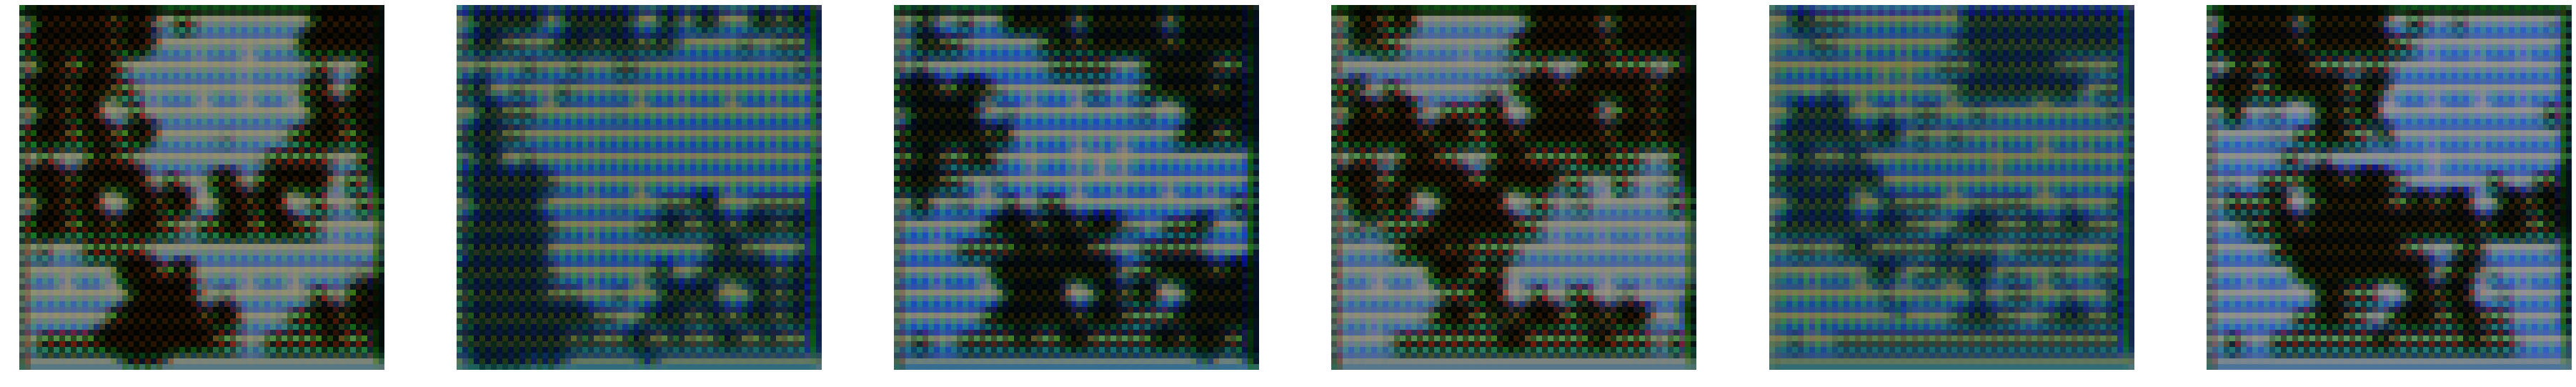

In [10]:
d_loss_log = []
g_loss_log = []
dout_real_log = []
dout_fake_log = []
dout_fake_log2 = []

iter_n = len(train_loader) - 1 #最後の余ったバッチは計算されないから-1

for epoch in range(epochs):
    
    epoch_g_loss = 0.0  # epochの損失和
    epoch_d_loss = 0.0  # epochの損失和
    epoch_dout_real = 0.0
    epoch_dout_fake = 0.0
    epoch_dout_fake2 = 0.0

    epoch_time = time.perf_counter()
    if time.perf_counter() - kernel_start_time > 31000:
            print("Time limit reached! Stopping kernel!"); break

    for ii, (real_images, dog_labels) in tqdm(enumerate(train_loader),total=len(train_loader)):
        if real_images.shape[0]!= BATCH_SIZE: continue
        
        # ラベルにノイズを入れる。そして時々fakeとrealを入れ替える。
        if use_soft_noisy_labels:
            real_labels = torch.squeeze(torch.empty((BATCH_SIZE, 1), device=device).uniform_(*R_uni))
            fake_labels = torch.squeeze(torch.empty((BATCH_SIZE, 1), device=device).uniform_(*F_uni))
            for p in np.random.choice(BATCH_SIZE, size=np.random.randint((BATCH_SIZE//8)), replace=False):
                real_labels[p], fake_labels[p] = fake_labels[p], real_labels[p] # swap labels
        else:
            real_labels = torch.full((BATCH_SIZE, 1), 1.0, device=device)
            fake_labels = torch.full((BATCH_SIZE, 1), 0.0, device=device)
        
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()

        dog_labels = torch.tensor(dog_labels, device=device)
        real_images = real_images.to(device)
        noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
        
        outputR = netD((real_images, dog_labels))
        fake_images = netG((noise, dog_labels))

        outputF = netD((fake_images.detach(), dog_labels))
        if loss_calc == 'rals':
            errD = (torch.mean((outputR - torch.mean(outputF) - real_labels) ** 2) + 
                    torch.mean((outputF - torch.mean(outputR) + real_labels) ** 2))/2
        elif loss_calc == 'hinge':
            d_loss_real = torch.nn.ReLU()(real_labels - outputR).mean()
            # 誤差　outputRがreal_labels以上で誤差0になる。outputR>1で、
            # real_labels - outputRが負の場合ReLUで0にする 
            d_loss_fake = torch.nn.ReLU()(real_labels + outputF).mean()
            # 誤差　outputFがreal_labels以下で誤差0になる。outputF>1で、
            # real_labels - outputFが負の場合ReLUで0にする
            errD = d_loss_real + d_loss_fake

        errD.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        
        outputF2 = netD((fake_images, dog_labels))
        if loss_calc == 'rals':
            errG = (torch.mean((outputR - torch.mean(outputF2) + real_labels) ** 2) +
                    torch.mean((outputF2 - torch.mean(outputR) - real_labels) ** 2))/2
        elif loss_calc == 'hinge':
            errG = - outputF2.mean()
            
        errG.backward()
        optimizerG.step()
        
        lr_schedulerG.step(epoch)
        lr_schedulerD.step(epoch)
        
        # --------------------
        # 3. 記録
        # --------------------
        epoch_d_loss += errD.item()
        epoch_g_loss += errG.item()
        epoch_dout_real += outputR.mean().item()
        epoch_dout_fake += outputF.mean().item()
        epoch_dout_fake2 += outputF2.mean().item()
        
    d_loss_log.append(epoch_d_loss/iter_n)
    g_loss_log.append(epoch_g_loss/iter_n)
    dout_real_log.append(epoch_dout_real/iter_n)
    dout_fake_log.append(epoch_dout_fake/iter_n)
    dout_fake_log2.append(epoch_dout_fake2/iter_n)

#     print('loss=%s 1epochの中での平均値 \n %.2fs [%d/%d] Loss_D: %.4f Loss_G: %.4f outputR: %.4f outputF: %.4f / %.4f' % (loss_calc,
#           time.perf_counter()-epoch_time, epoch+1, epochs, d_loss_log[-1], g_loss_log[-1],dout_real_log[-1], dout_fake_log[-1],dout_fake_log2[-1] ))
#     print('最後のバッチのloss等 \n %.2fs [%d/%d] Loss_D: %.4f Loss_G: %.4f outputR: %.4f outputF: %.4f / %.4f' % (
#         time.perf_counter()-epoch_time, epoch+1, epochs, errD.item(), errG.item(),outputR.mean().item(), outputF.mean().item(),outputF2.mean().item() ))

    if epoch % 10 == 0:
        show_generated_img(6)



## Visualise generated results by label and submit

In [11]:
good_breeds = analyse_generated_by_class(6)
create_submit(good_breeds)

Creating submit


ValueError: 'a' cannot be empty unless no samples are taken

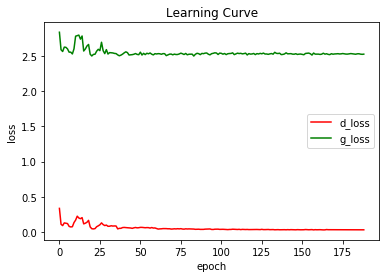

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(d_loss_log,   color="r", label="d_loss")
plt.plot(g_loss_log,   color="g", label="g_loss")

plt.legend(loc="best")

plt.show()

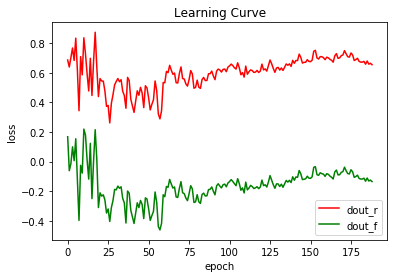

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(dout_real_log, color="r", label="dout_r")
plt.plot(dout_fake_log, color="g", label="dout_f")

plt.legend(loc="best")

plt.show()